In [29]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import math

import us
import plotly.graph_objects as go
import gmaps

import folium
from folium import plugins

from IPython.display import display
from PIL import Image

pd.set_option('display.max_columns', None)

%matplotlib inline 

In [30]:
market_df = pd.read_csv('data/cleaned_market_df.csv')
county_df = pd.read_csv('data/cleaned_county_df.csv')

# States

In [31]:
market_df['State'].unique()

array(['Vermont', 'Ohio', 'Missouri', 'New York', 'Tennessee', 'Delaware',
       'District of Columbia', 'Oregon', 'Minnesota', 'Virginia',
       'Pennsylvania', 'Nebraska', 'Illinois', 'Florida', 'Washington',
       'Kansas', 'New Jersey', 'Utah', 'Maryland', 'Indiana', 'Nevada',
       'Alabama', 'Iowa', 'South Carolina', 'Wisconsin', 'Massachusetts',
       'Louisiana', 'New Mexico', 'Oklahoma', 'Michigan', 'Georgia',
       'North Carolina', 'Arizona', 'California', 'Texas', 'Colorado',
       'West Virginia', 'Idaho', 'Montana', 'North Dakota', 'Kentucky',
       'Rhode Island', 'Arkansas', 'Mississippi', 'Maine', 'Connecticut',
       'New Hampshire', 'Wyoming', 'South Dakota'], dtype=object)

In [32]:
state_list = ['Vermont', 'Ohio', 'Missouri', 'New York', 'Tennessee', 'Delaware',
              'District of Columbia', 'Oregon', 'Minnesota', 'Virginia',
              'Pennsylvania', 'Nebraska', 'Illinois', 'Florida', 'Washington',
              'Kansas', 'New Jersey', 'Utah', 'Maryland', 'Indiana', 'Nevada',
              'Alabama', 'Iowa', 'South Carolina', 'Wisconsin', 'Massachusetts',
              'Louisiana', 'New Mexico', 'Oklahoma', 'Michigan', 'Georgia',
              'North Carolina', 'Arizona', 'California', 'Texas', 'Colorado',
              'West Virginia', 'Idaho', 'Montana', 'North Dakota', 'Kentucky',
              'Rhode Island', 'Arkansas', 'Mississippi', 'Maine', 'Connecticut',
              'New Hampshire', 'Wyoming', 'South Dakota']

alternative_pay_methods = [0,1,2,3,4]

In [33]:
state_df_col_names = ['State', 'has_website', 'alt_pay_methods', 'product_count']

In [34]:
state_df = market_df.copy()
state_df = state_df[state_df_col_names]

In [35]:
ser = state_df.groupby(['State', 'alt_pay_methods', 'has_website']).product_count.mean()

In [36]:
stack = ser.to_frame()
stack

product_count
State     alt_pay_methods has_website               
Alabama   0               0                 9.750000
                          1                10.555556
          1               0                 7.400000
                          1                11.153846
          2               0                 6.454545
...                                              ...
Wisconsin 4               1                17.705882
Wyoming   0               0                 9.833333
                          1                12.769231
          1               0                10.000000
                          1                16.000000

[421 rows x 1 columns]

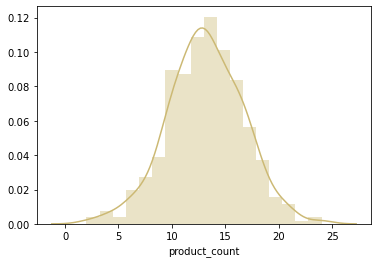

In [37]:
x = stack['product_count']

sns.set_color_codes()
ax = sns.distplot(x, color="y")

In [38]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile

In [39]:
total_market = market_df.groupby(["State"])["MarketName"].value_counts().groupby(["State"]).sum().sort_values(ascending=False).reset_index()
total_market = pd.DataFrame(total_market)
total_market.rename(columns={"MarketName": "Number of Markets"}, inplace=True)

In [40]:
total_market.head()

,State,Number of Markets
0,New York,492
1,California,459
2,Massachusetts,252
3,Michigan,247
4,Missouri,221


In [41]:
max_product_count = market_df.groupby(["State"])["product_count"].value_counts().groupby(["State"]).max().sort_values(ascending=False).reset_index()
max_product_count = pd.DataFrame(max_product_count)
max_product_count.rename(columns={"product_count": "Max Product Count"}, inplace=True)

In [42]:
max_product_count.head()

,State,Max Product Count
0,California,37
1,New York,37
2,Missouri,29
3,Massachusetts,25
4,Wisconsin,25


In [43]:
min_product_count = market_df.groupby(["State"])["product_count"].value_counts().groupby(["State"]).min().sort_values(ascending=False).reset_index()
min_product_count = pd.DataFrame(min_product_count)
min_product_count.rename(columns={"product_count": "Min Product Count"}, inplace=True)

In [44]:
min_product_count.head()

,State,Min Product Count
0,Wyoming,1
1,Missouri,1
2,Minnesota,1
3,Michigan,1
4,Massachusetts,1


In [45]:
state_counts_df = total_market.copy()

In [46]:
state_counts_df = state_counts_df.merge(max_product_count, on='State')
state_counts_df = state_counts_df.merge(min_product_count, on='State')

In [47]:
state_counts_df.head()

,State,Number of Markets,Max Product Count,Min Product Count
0,New York,492,37,1
1,California,459,37,1
2,Massachusetts,252,25,1
3,Michigan,247,24,1
4,Missouri,221,29,1


# Visualizations

In [50]:
# list of all the unique states in the data set
states = list(county_df['State'].unique())

states_coded = []

# obtains the FIPS code from state name
for state in states:
    states_coded.append(us.states.lookup(state).abbr)

In [52]:
# ready to create state-level data set
state_info = pd.DataFrame()

# retain state names in state-level data set for reference
state_info['State'] = states

# FIPS code of each state
state_info['State code'] = states_coded

# variables to be included in new data set
cols = ['Per capita income', 'Population', 'Number of households', 'Number of markets']

# initialisation
for var in cols:
    state_info[var] = ''

temp = []

# computation for state-level variables
for i in range(len(states)):
    num_household = 0
    
    # dataframe of all counties in state state[i]
    state_df = pd.DataFrame(county_df.loc[county_df['State'] == states[i], :]).reset_index()
    
    total_popn = sum(state_df['population'])
    state_info.loc[i, 'Population'] = total_popn
    state_info.loc[i, 'Number of households'] = state_df['number of households'].sum()
    state_info.loc[i, 'Number of markets'] = market_df[market_df['State'] == states[i]].shape[0]
    temp += [round(state_df['per capita income'].dot(state_df['population'] / total_popn))]

state_info['Per capita income'] = temp
state_info['Per capita income'] = state_info['Per capita income'].astype(int)

state_info.head()

,State,State code,Per capita income,Population,Number of households,Number of markets
0,New York,NY,32382,19487053,7234743,492
1,Virginia,VA,33493,8100653,3022739,205
2,California,CA,29527,37659181,12542460,459
3,Colorado,CO,31109,5119329,1977591,102
4,New Mexico,NM,23763,2069706,761938,48
